# 1. Подключение библиотек

In [1]:
# Read data
from google.colab import files
import os
import struct

import torch
import numpy as np

# Test
import numpy.testing as npt
import unittest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# 2. Загрузка датасета

In [2]:
#@title Загрузка архивов в Google Colab

# Если не скачано, скачать
if not os.path.isfile('train-images.idx3-ubyte.zip'):
    uploaded = files.upload()
else:
    print('Files have already been installed.')

Saving t10k-labels.idx1-ubyte to t10k-labels.idx1-ubyte
Saving t10k-images.idx3-ubyte.zip to t10k-images.idx3-ubyte.zip
Saving train-labels.idx1-ubyte to train-labels.idx1-ubyte
Saving train-images.idx3-ubyte.zip to train-images.idx3-ubyte.zip


In [3]:
#@title Распаковка архивов

!unzip train-images.idx3-ubyte.zip
!unzip t10k-images.idx3-ubyte.zip

Archive:  train-images.idx3-ubyte.zip
  inflating: train-images.idx3-ubyte  
Archive:  t10k-images.idx3-ubyte.zip
  inflating: t10k-images.idx3-ubyte  


In [4]:
#@title Вспомогательные методы для считывания данных в numpy формат

def load_images(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(num, rows, cols)

def load_labels(path):
    with open(path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        assert magic == 2049
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

In [5]:
#@title Сохраняем датасет

train_images = load_images("train-images.idx3-ubyte")
train_labels = load_labels("train-labels.idx1-ubyte")

test_images = load_images("t10k-images.idx3-ubyte")
test_labels = load_labels("t10k-labels.idx1-ubyte")

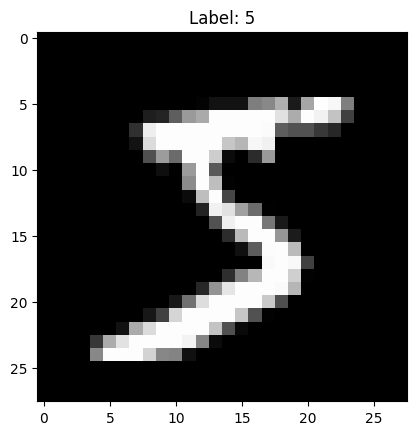

In [6]:
#@title Проверка данных

plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()

# 3. Реализация основных классов нейронной сети

In [7]:
#@title ReLu

class ReLU:
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        self.mask = (x > 0).astype(np.float32)
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * self.mask

    # No weights (layer parameters)
    def update_weights(self, learning_rate):
        pass

In [8]:
#@title Softmax

class Softmax:
    def __init__(self):
        self.softmax = None

    def forward(self, x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.softmax = exp / np.sum(exp, axis=1, keepdims=True)
        return self.softmax

    def backward(self, grad_output):
        dot = np.sum(self.softmax * grad_output, axis=1, keepdims=True)
        return self.softmax * (grad_output - dot)

    # No weights (layer parameters)
    def update_weights(self, learning_rate):
        pass

In [9]:
#@title Linear

class Linear:
    def __init__(self, in_features, out_features):
        # Xavier initialization
        limit = np.sqrt(6 / (in_features + out_features))
        self.W = np.random.uniform(-limit, limit, (in_features, out_features))
        self.b = np.zeros((1, out_features))

        # Gradient
        self.dW = None
        self.db = None

        # Cache
        self.x = None

    def forward(self, x):
        """
        x.shape: (batch_size, in_features)
        self.W.shape: (in_features, out_features)
        """
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_output):
        """
        grad_output.shape: (batch_size, out_features)
        """
        self.dW = self.x.T @ grad_output
        self.db = np.sum(grad_output, axis=0, keepdims=True)

        grad_input = grad_output @ self.W.T

        return grad_input

    def update_weights(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db

In [10]:
#@title Многослойный перцептрон

class MLP:
    def __init__(self, input_dim=784, hidden_dim=128, num_classes=10):
        self.layers = [
            Linear(input_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, num_classes),
            Softmax()
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def update_weights(self, learning_rate):
        for layer in self.layers:
            if hasattr(layer, "update_weights"):
                layer.update_weights(learning_rate)

    def predict(self, x):
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

In [11]:
#@title MSELoss

class MSELoss:
    def __init__(self):
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean((y_pred - y_true) ** 2)

    def backward(self):
        batch = self.y_pred.shape[0]
        return 2 * (self.y_pred - self.y_true) / batch

# 4. Тестирование классов на их корректность

In [12]:
#@title One-hot кодирование целевого признака (класса)

def one_hot(y, num_classes=10):
    out = np.zeros((y.size, num_classes))
    out[np.arange(y.size), y] = 1
    return out

In [13]:
#@title Тестирование ReLU на корректность

class TestReLU(unittest.TestCase):
    def test_forward_relu(self):
        ''' Test ReLU forward method '''
        x = torch.randn((10000, 784), dtype=torch.float32)

        expected = torch.nn.ReLU()(x)
        actual = ReLU().forward(x.numpy())

        npt.assert_allclose(expected.detach().numpy(), actual, rtol=1e-6, atol=1e-6)

    def test_backward_relu(self):
        ''' Test ReLU backward method '''
        x = torch.randn((10000, 784), dtype=torch.float32, requires_grad=True)
        grad_output = torch.randn_like(x)

        # Torch
        torch_relu = torch.nn.ReLU()

        y = torch_relu(x)
        y.backward(grad_output)
        grad_expected = x.grad.detach().numpy()
        x.grad = None

        # Custom impl
        custom_relu = ReLU()

        custom_relu.forward(x.detach().numpy())
        grad_actual = custom_relu.backward(grad_output.detach().numpy())

        npt.assert_allclose(grad_expected, grad_actual, rtol=1e-6, atol=1e-6)

In [14]:
#@title Тестирование Softmax на корректность

class TestSoftmax(unittest.TestCase):
    def test_forward_softmax(self):
        ''' Test Softmax forward method '''
        # multiply by a large number to check
        # the stability of softmax
        x = torch.randn((10000, 10), dtype=torch.float32) * 50

        expected = torch.nn.Softmax(dim=-1)(x)
        actual = Softmax().forward(x.numpy())

        npt.assert_allclose(expected, actual, rtol=1e-6, atol=1e-6)

    def test_backward_softmax(self):
        ''' Test Softmax backward method '''
        # multiply by a large number to check
        # the stability of softmax
        x = torch.randn((10000, 10), dtype=torch.float32) * 50
        x = x.clone().detach().requires_grad_(True)

        grad_output = torch.randn_like(x)

        # Torch
        torch_softmax = torch.nn.Softmax(dim=-1)

        y = torch_softmax(x)
        y.backward(grad_output)
        grad_expected = x.grad.detach().numpy()
        x.grad = None

        # Custom impl
        custom_softmax = Softmax()

        custom_softmax.forward(x.detach().numpy())
        grad_actual = custom_softmax.backward(grad_output.detach().numpy())

        npt.assert_allclose(grad_expected, grad_actual, rtol=1e-6, atol=1e-6)

In [15]:
#@title Тестирование Linear на корректность

class TestLinear(unittest.TestCase):
    def test_forward_linear(self):
        ''' Test Linear forward method '''
        x = torch.randn((10000, 784), dtype=torch.float32)

        # Torch
        torch_linear = torch.nn.Linear(784, 128)
        w = torch_linear.weight.transpose(-1, -2).contiguous()
        b = torch_linear.bias
        expected = torch_linear(x)

        # Custom impl
        custom_linear = Linear(784, 128)
        custom_linear.W = w.detach().numpy()
        custom_linear.b = b.detach().numpy()
        actual = custom_linear.forward(x.detach().numpy())

        npt.assert_allclose(expected.detach().numpy(), actual, rtol=1e-5, atol=1e-5)

    def test_backward_linear(self):
        ''' Test Linear backward method '''
        x = torch.randn((10000, 784), dtype=torch.float32, requires_grad=True)
        grad_output = torch.randn((10000, 128), dtype=torch.float32)

        # Torch
        torch_linear = torch.nn.Linear(784, 128)
        w = torch_linear.weight.transpose(-1, -2).contiguous()
        b = torch_linear.bias

        y = torch_linear(x)
        y.backward(grad_output)
        grad_expected = x.grad.detach().numpy()

        # Custom impl
        custom_linear = Linear(784, 128)
        custom_linear.W = w.detach().numpy()
        custom_linear.b = b.detach().numpy()
        custom_linear.forward(x.detach().numpy())
        grad_actual = custom_linear.backward(grad_output.detach().numpy())

        npt.assert_allclose(grad_expected, grad_actual, rtol=1e-5, atol=1e-5)

In [16]:
#@title Тестирование MSELoss на корректность

class TestMSELoss(unittest.TestCase):
    def test_forward_mse_loss(self):
        ''' Test MSELoss forward method '''
        y_pred = one_hot(torch.randint(0, 10, (10000,)).numpy())
        y_actual = one_hot(torch.randint(0, 10, (10000,)).numpy())

        expected = torch.nn.MSELoss()(torch.from_numpy(y_pred), torch.from_numpy(y_actual))
        actual = MSELoss().forward(y_pred, y_actual)

        npt.assert_allclose(expected.numpy(), actual, rtol=1e-5, atol=1e-5)

    def test_backward_mse_loss(self):
        y_pred = torch.from_numpy(one_hot(torch.randint(0, 10, (10000,)).numpy()))
        y_pred = y_pred.clone().detach().requires_grad_(True)
        y_actual = torch.from_numpy(one_hot(torch.randint(0, 10, (10000,)).numpy()))

        # Torch
        torch_mse_loss = torch.nn.MSELoss()
        loss = torch_mse_loss(y_pred, y_actual)
        loss.backward()
        grad_expected = y_pred.grad.detach().numpy()

        # Custom impl
        custom_mse_loss = MSELoss()
        custom_mse_loss.forward(y_pred.detach().numpy(), y_actual.detach().numpy())
        grad_actual = custom_mse_loss.backward()

        npt.assert_allclose(grad_expected, grad_actual, rtol=1e-3, atol=1e-3)

In [17]:
#@title Запуск тестов

unittest.main(argv=[''], verbosity=2, exit=False)

test_backward_linear (__main__.TestLinear.test_backward_linear)
Test Linear backward method ... ok
test_forward_linear (__main__.TestLinear.test_forward_linear)
Test Linear forward method ... ok
test_backward_mse_loss (__main__.TestMSELoss.test_backward_mse_loss) ... ok
test_forward_mse_loss (__main__.TestMSELoss.test_forward_mse_loss)
Test MSELoss forward method ... ok
test_backward_relu (__main__.TestReLU.test_backward_relu)
Test ReLU backward method ... ok
test_forward_relu (__main__.TestReLU.test_forward_relu)
Test ReLU forward method ... ok
test_backward_softmax (__main__.TestSoftmax.test_backward_softmax)
Test Softmax backward method ... ok
test_forward_softmax (__main__.TestSoftmax.test_forward_softmax)
Test Softmax forward method ... ok

----------------------------------------------------------------------
Ran 8 tests in 2.075s

OK


# 5. Тренировка и проверка качества

In [18]:
#@title Метод для тренировки модели

def train(model, X_train, y_train, epochs=3, batch_size=64, learning_rate=1e-3, verbose=False):
    loss_func = MSELoss()
    num_samples = X_train.shape[0]

    for epoch in range(epochs):
        perm = np.random.permutation(num_samples)
        X_train = X_train[perm]
        y_train = y_train[perm]

        total_loss = 0

        for i in range(0, num_samples, batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # forward
            y_pred = model.forward(x_batch)
            y_true = one_hot(y_batch)

            # loss
            loss = loss_func.forward(y_pred, y_true)
            total_loss += loss

            # backward
            grad_loss = loss_func.backward()
            model.backward(grad_loss)

            # update weights
            model.update_weights(learning_rate)

        if verbose:
            print(f"Epoch {epoch+1}, loss={total_loss:.4f}")

In [19]:
#@title Метрика качества

def accuracy(model, X, y):
    preds = model.predict(X)
    return np.mean(preds == y)

In [20]:
#@title Запуск

model = MLP(hidden_dim=128)

# Normalization
X_train = train_images.reshape(-1, 784) / 255
y_train = train_labels

# Normalization
X_test = test_images.reshape(-1, 784) / 255
y_test = test_labels

train(model, X_train, y_train, epochs=50, batch_size=128, learning_rate=0.01, verbose=True)

acc = accuracy(model, X_test, y_test)
print("Test accuracy:", acc)

Epoch 1, loss=35.9924
Epoch 2, loss=21.9159
Epoch 3, loss=14.6025
Epoch 4, loss=11.5878
Epoch 5, loss=10.0824
Epoch 6, loss=9.1772
Epoch 7, loss=8.5597
Epoch 8, loss=8.1037
Epoch 9, loss=7.7498
Epoch 10, loss=7.4621
Epoch 11, loss=7.2213
Epoch 12, loss=7.0154
Epoch 13, loss=6.8382
Epoch 14, loss=6.6797
Epoch 15, loss=6.5324
Epoch 16, loss=6.4058
Epoch 17, loss=6.2863
Epoch 18, loss=6.1767
Epoch 19, loss=6.0770
Epoch 20, loss=5.9846
Epoch 21, loss=5.8941
Epoch 22, loss=5.8114
Epoch 23, loss=5.7325
Epoch 24, loss=5.6575
Epoch 25, loss=5.5857
Epoch 26, loss=5.5180
Epoch 27, loss=5.4518
Epoch 28, loss=5.3919
Epoch 29, loss=5.3315
Epoch 30, loss=5.2711
Epoch 31, loss=5.2155
Epoch 32, loss=5.1624
Epoch 33, loss=5.1094
Epoch 34, loss=5.0546
Epoch 35, loss=5.0054
Epoch 36, loss=4.9588
Epoch 37, loss=4.9114
Epoch 38, loss=4.8645
Epoch 39, loss=4.8197
Epoch 40, loss=4.7766
Epoch 41, loss=4.7331
Epoch 42, loss=4.6925
Epoch 43, loss=4.6516
Epoch 44, loss=4.6102
Epoch 45, loss=4.5687
Epoch 46, loss